# 1. Import libraries and dataset

Here we import the libraries that will be useful for the notebook:

In [ ]:
import pandas as pd
import tensorflow as tf
import random
import numpy as np
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.metrics import f1_score
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from sklearn.metrics import classification_report
import keras
import os
import subprocess

def get_gpu_memory():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8').strip()
    gpu_memory = int(output)
    return gpu_memory

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
if tf.test.gpu_device_name():
    print('GPU is available')
    gpu_memory_gb = get_gpu_memory() / 1024
    print(f"GPU memory: {gpu_memory_gb} GB")
else:
    print('No GPU found')

GPU is available
GPU memory: 11.0 GB


Then, we set the seed:

In [ ]:
seed_value = 42

# Set the seed for Numpy
np.random.seed(seed_value)

# Set the seed for TensorFlow
tf.random.set_seed(seed_value)
random.seed(seed_value)

And finally import the Dataset from the UCI Machine Learning repository:

(https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip)

Since the dataset are .txt files, we need to convert them to Pandas Dataframes;

In [ ]:
x_train = pd.read_table('UCI HAR Dataset/train/X_train.txt', header=None)
x_test = pd.read_table('UCI HAR Dataset/test/X_test.txt', header=None)
y_train = pd.read_table('UCI HAR Dataset/train/y_train.txt', header=None)
y_test = pd.read_table('UCI HAR Dataset/test/y_test.txt', header=None)

In addition, the 561 attributes have been saved in a single string element, so we use the following funtion to convert each row of the dataset to a series of proper length

In [ ]:
def convert_to_series(el):
    elements = el.split()
    list_el= list(map(float, elements))
    el_series = pd.Series(list_el)
    return el_series

In [ ]:
x_train_1 = x_train[0].apply(lambda x: convert_to_series(x))
X_test = x_test[0].apply(lambda x: convert_to_series(x))

Since the Dataset only provides a training and test set, we need to split the former to obtain a validation set for the hyperparameters tuning

In [ ]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_1, y_train, test_size=0.1, random_state=42)

Let's now see some information about the three Dataset obtained:

In [ ]:
print('The shape of the training set is: {}'.format(X_train.shape))
print('The shape of the val set is:      {}'.format(X_val.shape))
print('The shape of the test set is:     {}'.format(X_test.shape))
print('The number of classes is:         {}'.format(len(y_train[0].unique())))

The shape of the training set is: (6616, 561)
The shape of the val set is:      (736, 561)
The shape of the test set is:     (2947, 561)
The number of classes is:         6


So each sample has a size of 561 features. Then, Let's see the distribution of the 6 classes over the different dataframes (train, val and test):

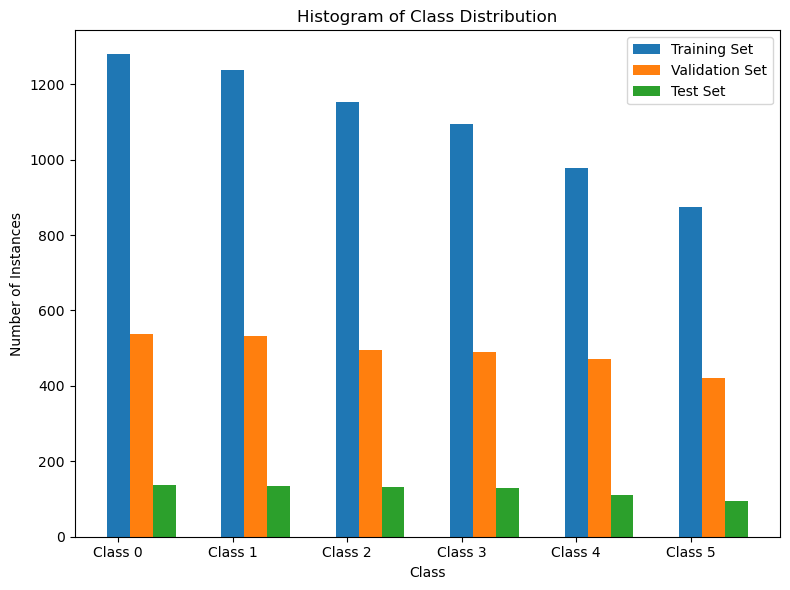

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Replace with your actual class labels

value_counts = [df.value_counts() for df in [y_train, y_test, y_val]]

# Get the maximum count across all dataframes
max_count = max([vc.max() for vc in value_counts])

# Create the x-axis positions for the bars
x_pos = np.arange(len(class_labels))

# Plot the histogram with overlapped bars
plt.figure(figsize=(8, 6))
for i, vc in enumerate(value_counts):
    plt.bar(x_pos + i * 0.2, vc, width=0.2, align='center')

plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Histogram of Class Distribution')
plt.xticks(x_pos, class_labels)
plt.legend(['Training Set', 'Validation Set', 'Test Set'])  # Add legend for each dataframe
plt.tight_layout()
plt.show()

As we can see, each class has almost the same number of samples in each split. In addition, the three splits have the same classes distribution:

In [ ]:
dataframes = [y_train, y_test, y_val]

# Calculate the value counts for each dataframe
value_counts = [df.iloc[:, 0].value_counts() for df in dataframes]  # Assuming a single column in each dataframe

# Get the unique classes
classes = set()
for vc in value_counts:
    classes.update(vc.index)
classes = sorted(classes)

# Print the header row
header = "Class".ljust(10)
headers = ["Training Set", "Validation Set", "Test Set"]
for i, header_text in enumerate(headers):
    header += f" | {header_text}".ljust(18)
print(header)

# Print the separator row
separator = "".ljust(10)
for i in range(1, len(dataframes) + 1):
    separator += " |=====".ljust(18, "=")
print(separator)

# Iterate over the classes and print the percentages for each dataframe
for class_label in classes:
    row = str(class_label).ljust(10)
    for i, vc in enumerate(value_counts):
        total_values = vc.sum()
        count = vc[class_label] if class_label in vc else 0
        percentage = (count / total_values) * 100
        if i > 0:
            row += " "  
        row += f" | {percentage:.2f}%".ljust(17) 
    print(row)

Class      | Training Set    | Validation Set  | Test Set       
           |================ |================ |================
1          | 16.54%          | 16.83%          | 17.93%        
2          | 14.80%          | 15.98%          | 12.77%        
3          | 13.23%          | 14.25%          | 15.08%        
4          | 17.41%          | 16.66%          | 18.21%        
5          | 18.70%          | 18.05%          | 18.61%        
6          | 19.33%          | 18.22%          | 17.39%        


In the end, let's convert the Dataframes into NumPy arrays (which are suitable for the Keras model):

and also the labels in the one-hot encoding form (required by Keras):

In [ ]:
y_train_1 = tf.keras.utils.to_categorical(y_train-1, num_classes = 6)
y_val_1 = tf.keras.utils.to_categorical(y_val-1, num_classes = 6)
y_test_1 = tf.keras.utils.to_categorical(y_test-1, num_classes = 6)

# 2. Test a Baseline Model for the raw input

Let's now try to evaluate the performance of a Baseline model that make predictions on the raw inputs, which are the initial samples with 561 features. First, let's the define the micro F1 score that will be used as metrics to check overfitting:

In [ ]:
def micro_f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Now, let's define the Baseline model. This will be a Neural Network with only Dense Layers. Since the input dimensionality is very high compared to the number of samples, dense layers with a very high number of nodes lead to overfitting and unstable training. For this reason, we chose a low number of neurons compared to the input size, performing the tuning of this and other hyperparameters on the validation set:

In [ ]:
num_classes = 6
input_size = (561,)
n_epochs = 20
batch_size = 32

In [ ]:
# Define the input layer
inputs = keras.Input(shape=input_size, name = 'Input_Layer')

# Define the model architecture
x = keras.layers.Dense(64, activation='relu', name = '1_Dense')(inputs)
x = Dropout(0.4, name = 'Dropout_Layer')(x)  # Apply dropout with a rate of 0.3
x = keras.layers.Dense(32, activation='relu', name = '2_Dense')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax', name = 'Output_Layer')(x)

# Create the model
model561 = keras.Model(inputs=inputs, outputs=outputs, name = 'model_561_features')
model561.summary()

Model: "model_561_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 561)]             0         
                                                                 
 1_Dense (Dense)             (None, 64)                35968     
                                                                 
 Dropout_Layer (Dropout)     (None, 64)                0         
                                                                 
 2_Dense (Dense)             (None, 32)                2080      
                                                                 
 Output_Layer (Dense)        (None, 6)                 198       
                                                                 
Total params: 38,246
Trainable params: 38,246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model561.compile(loss='binary_crossentropy', optimizer='adam', metrics=[micro_f1])
# Train the model with the callback
history561 = model561.fit(X_train, y_train_1, batch_size= batch_size, epochs=n_epochs, validation_data=(X_val, y_val_1), callbacks=[early_stopping])

Epoch 1/20
207/207 [==============================] - 1s 2ms/step - loss: 0.2705 - micro_f1: 0.5605 - val_loss: 0.1429 - val_micro_f1: 0.8675
Epoch 2/20
207/207 [==============================] - 0s 1ms/step - loss: 0.1290 - micro_f1: 0.8503 - val_loss: 0.0800 - val_micro_f1: 0.9238
Epoch 3/20
207/207 [==============================] - 0s 1ms/step - loss: 0.0920 - micro_f1: 0.8949 - val_loss: 0.0532 - val_micro_f1: 0.9457
Epoch 4/20
207/207 [==============================] - 0s 1ms/step - loss: 0.0708 - micro_f1: 0.9217 - val_loss: 0.0437 - val_micro_f1: 0.9572
Epoch 5/20
207/207 [==============================] - 0s 1ms/step - loss: 0.0603 - micro_f1: 0.9312 - val_loss: 0.0392 - val_micro_f1: 0.9613
Epoch 6/20
207/207 [==============================] - 0s 1ms/step - loss: 0.0528 - micro_f1: 0.9409 - val_loss: 0.0287 - val_micro_f1: 0.9674
Epoch 7/20
207/207 [==============================] - 0s 1ms/step - loss: 0.0456 - micro_f1: 0.9465 - val_loss: 0.0251 - val_micro_f1: 0.9755
Epoch 

Let's now see the loss function and the micro F1 score over the epochs:

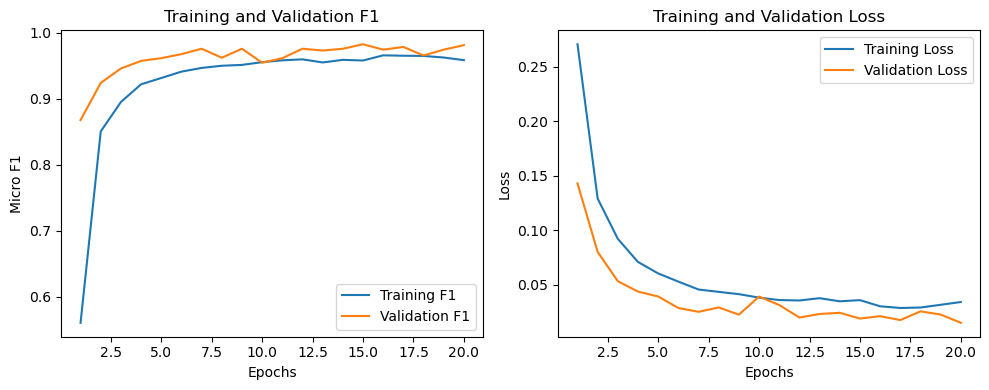

In [ ]:
# Get the training and validation loss from the history
training_f1 = history561.history['micro_f1']
validation_f1 = history561.history['val_micro_f1']
training_loss = history561.history['loss']
validation_loss = history561.history['val_loss']

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the Training and Validation F1 subplot
axs[0].plot(range(1, len(training_f1) + 1), training_f1, label='Training F1')
axs[0].plot(range(1, len(validation_f1) + 1), validation_f1, label='Validation F1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Micro F1')
axs[0].set_title('Training and Validation F1')
axs[0].legend()

# Plot the Training and Validation Loss subplot
axs[1].plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
axs[1].plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

As we can see, the training is stable and there is no sign of overfitting. Let's see the performance on the test set:

In [ ]:
train_f1 = micro_f1(y_train_1, model561.predict(X_train, verbose=0)).numpy()
print("Micro F1 score on the training set: {:.2f}".format(train_f1))
test_f1 = micro_f1(y_test_1, model561.predict(X_test, verbose=0)).numpy()
print("Micro F1 score on the test set:     {:.2f}".format(test_f1))

Micro F1 score on the training set: 0.98
Micro F1 score on the test set:     0.95


Again there are no signs of overfitting. Let's print the classification report

In [ ]:
# Make predictions on the test data
y_pred_prob = model561.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_1 = tf.keras.utils.to_categorical(y_pred, num_classes = 6)

# Print the classification report
print(classification_report(y_test_1, y_pred_1))


              precision    recall  f1-score   support

           0       0.92      0.99      0.96       496
           1       0.97      0.93      0.95       471
           2       0.99      0.95      0.97       420
           3       0.95      0.88      0.91       491
           4       0.87      0.96      0.91       532
           5       1.00      0.96      0.98       537

   micro avg       0.95      0.95      0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947
 samples avg       0.95      0.95      0.95      2947



In [ ]:
# save the model
model561.save('models_weights/model_561_features.h5')

# 3. Variance Selection

Since the input size is very high (561 input features) we need to reduce to obtain a model with less parameters. As feature selection techinques, here we choose the top K features (with k as hyperparameters) according to their variance --> so only the K features with the highest variance are chosen:

In [ ]:
import pandas as pd
# Calculate the variance for each feature
df = pd.DataFrame(X_train)
variances = df.var()

Then, we fine-tune the value of the variance from 40 to 150 for finding the best configurations:

In [ ]:
from tqdm import tqdm

histories = []

for current_var in tqdm(range(5,18)):
    
    # Select the top var features with the highest variance
    selected_features = variances.nlargest(current_var*10).index

    # Create a new DataFrame with only the selected features
    df_selected = df[selected_features]
    
    # Sort the values for taking the best values
    ind_features = sorted(df_selected.columns.values.tolist())
    
    X_train_var = X_train.loc[:,ind_features]
    X_val_var = X_val.loc[:,ind_features]
    X_test_var = X_test.loc[:,ind_features]

    num_classes = 6

    # Define the input layer
    inputs = keras.Input(shape=(X_train_var.shape[1],))

    # Define the model architecture
    x = keras.layers.Dense(X_train_var.shape[1]//2, activation='relu', name = '1_Dense')(inputs)
    x = Dropout(0.2, name = 'Dropout_Layer')(x)  # Apply dropout with a rate of 0.2
    x = keras.layers.Dense(X_train_var.shape[1]//4, activation='relu', name = '2_Dense')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name = 'model_features_selected')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[micro_f1])

    # Train the model with the callback
    history = model.fit(X_train_var, y_train_1, batch_size=32, epochs=15, 
                        validation_data=(X_val_var, y_val_1), callbacks=[early_stopping], verbose=0)
    histories.append((current_var,history))
    keras.models.save_model(model, 
                            'models_weigths/' + 'Dense' + str(current_var*10) + ".h5")

100%|██████████| 13/13 [00:41<00:00,  3.16s/it]


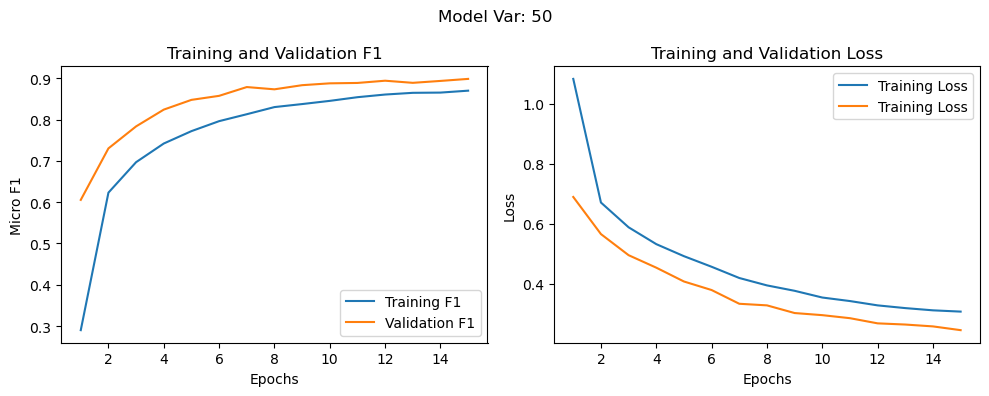

Micro F1 score on the training set: 0.90
Micro F1 score on the validation set: 0.90


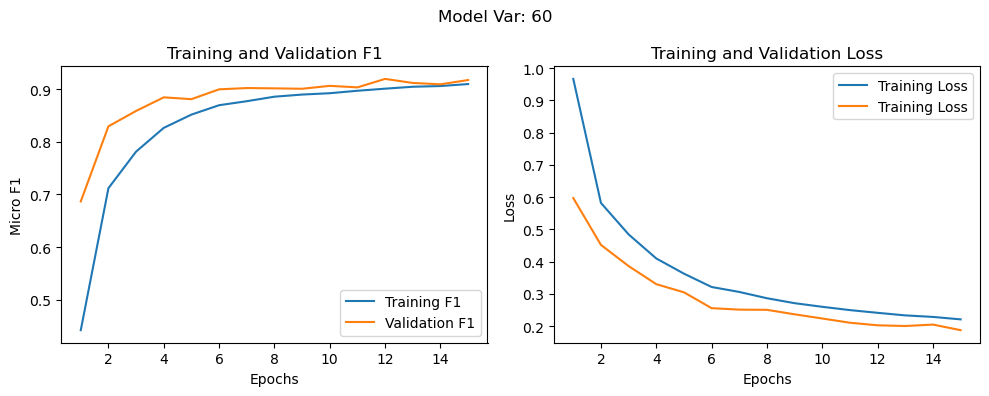

Micro F1 score on the training set: 0.93
Micro F1 score on the validation set: 0.92


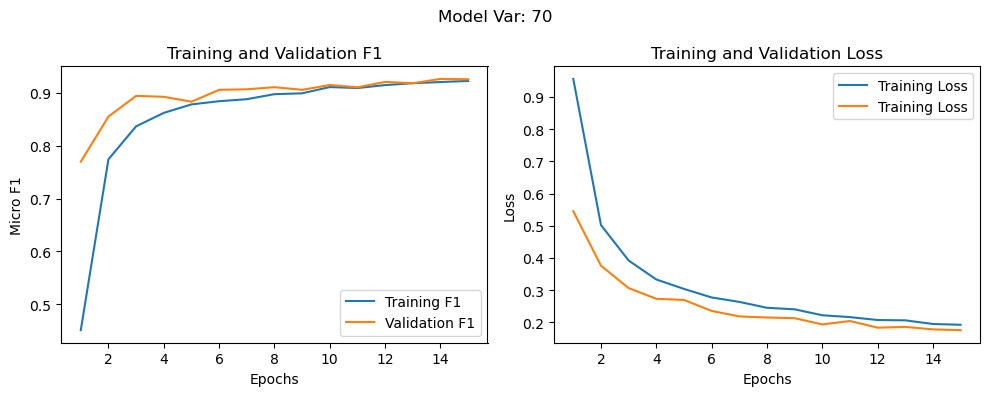

Micro F1 score on the training set: 0.94
Micro F1 score on the validation set: 0.93


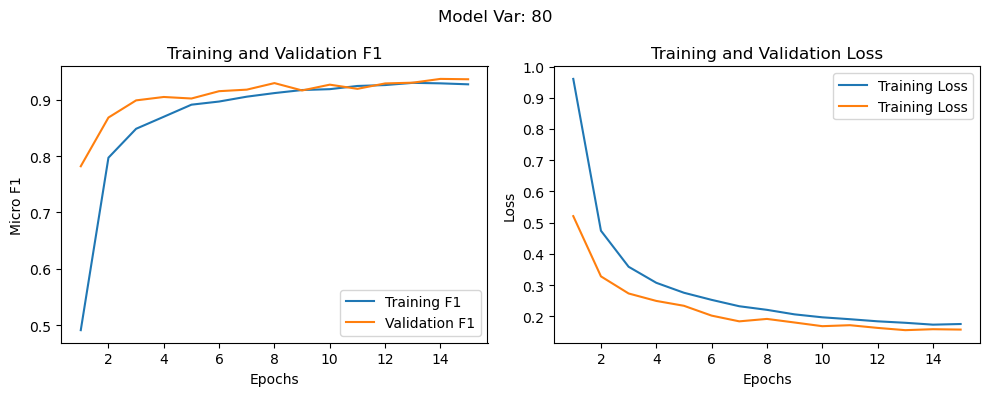

Micro F1 score on the training set: 0.95
Micro F1 score on the validation set: 0.94


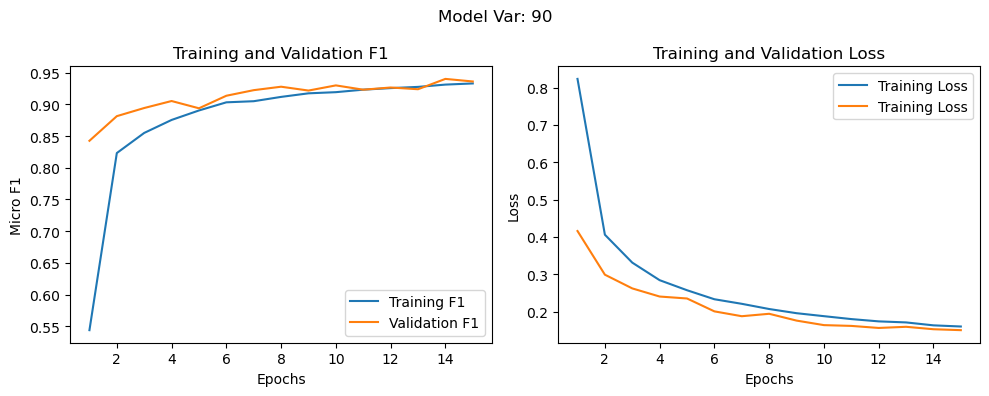

Micro F1 score on the training set: 0.94
Micro F1 score on the validation set: 0.94


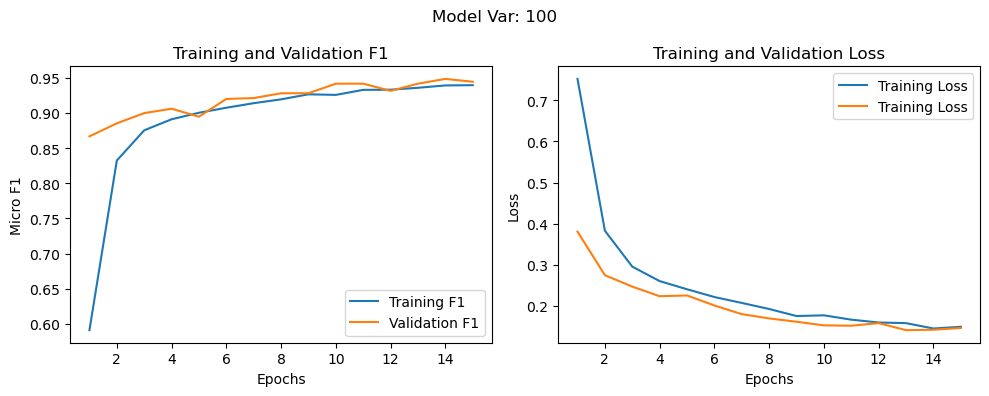

Micro F1 score on the training set: 0.95
Micro F1 score on the validation set: 0.94


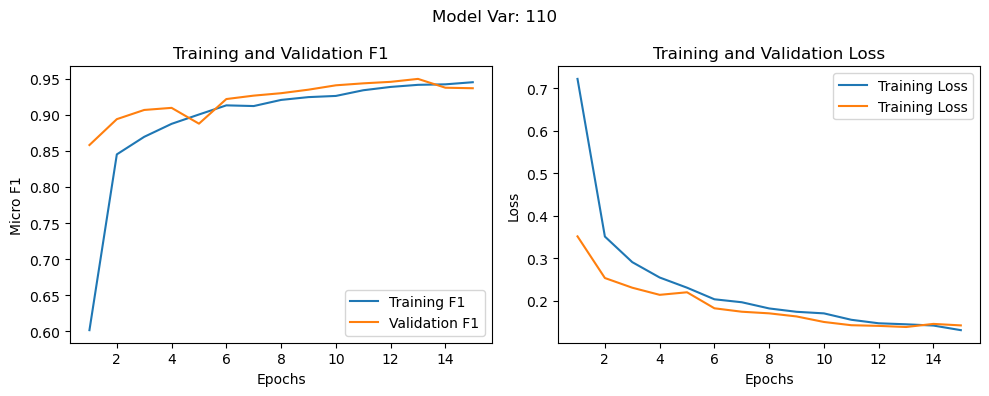

Micro F1 score on the training set: 0.96
Micro F1 score on the validation set: 0.94


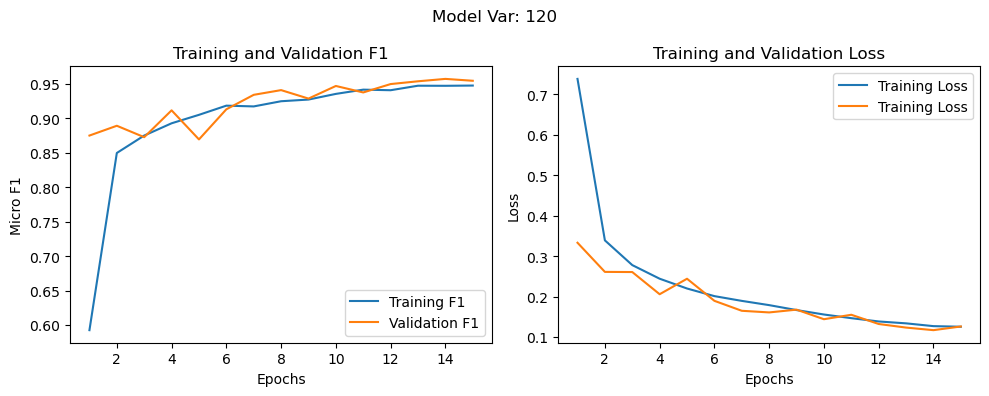

Micro F1 score on the training set: 0.96
Micro F1 score on the validation set: 0.95


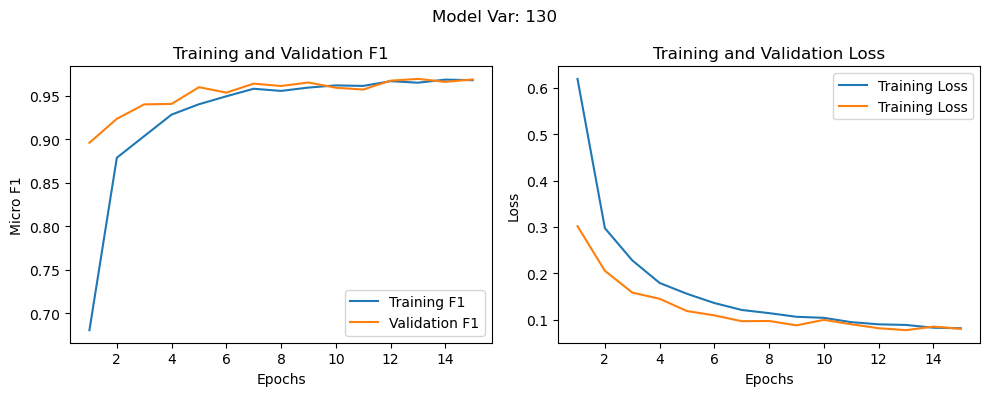

Micro F1 score on the training set: 0.98
Micro F1 score on the validation set: 0.97


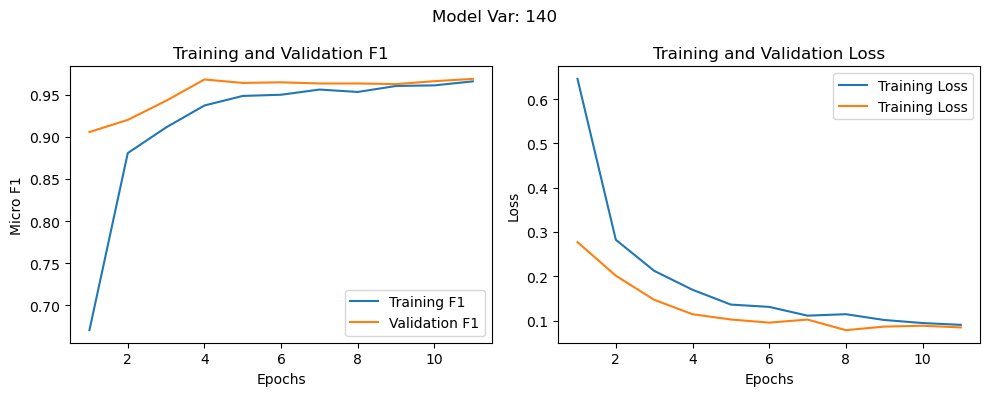

Micro F1 score on the training set: 0.97
Micro F1 score on the validation set: 0.97


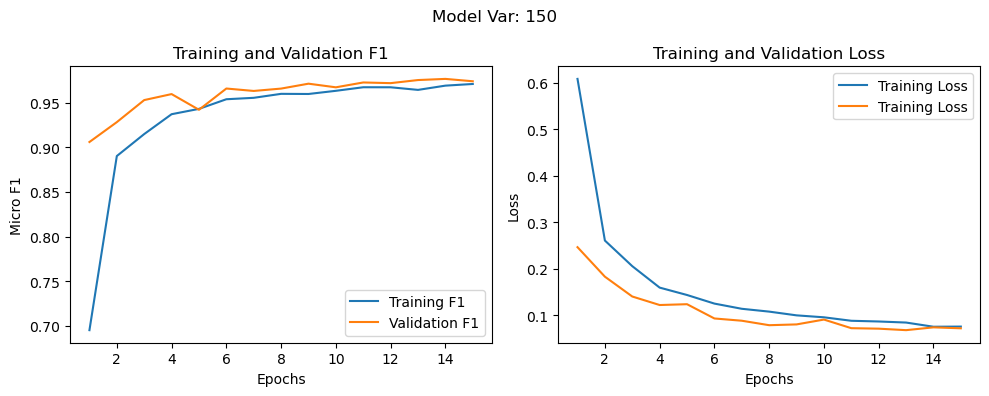

Micro F1 score on the training set: 0.97
Micro F1 score on the validation set: 0.97


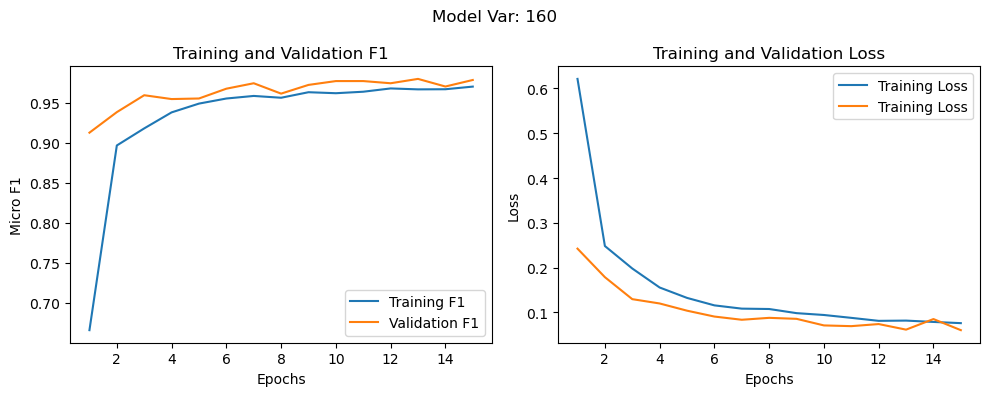

Micro F1 score on the training set: 0.98
Micro F1 score on the validation set: 0.98


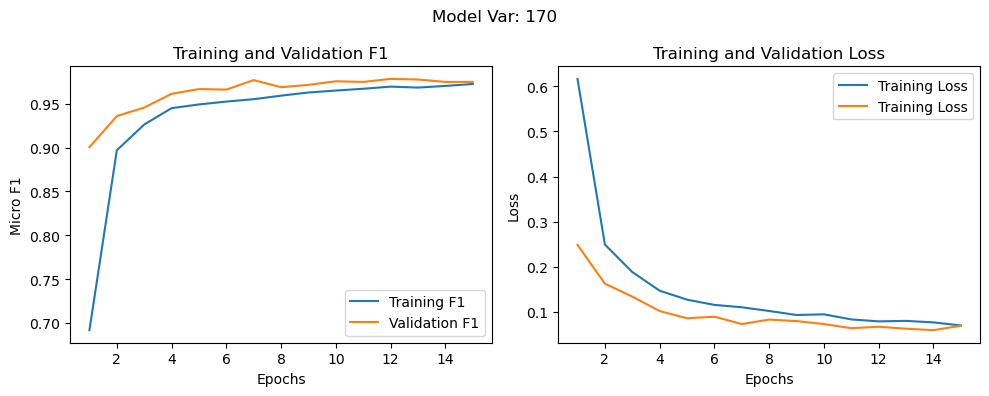

Micro F1 score on the training set: 0.98
Micro F1 score on the validation set: 0.97


In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras.utils as keras_utils

keras_utils.get_custom_objects()['micro_f1'] = micro_f1

for current_var, current_history in histories:
    current_model = keras.models.load_model('models_weights/' + 'Dense' + str(current_var*10) + ".h5",
                                            custom_objects={"custom_metric":"micro_f1"})
    
    selected_features = variances.nlargest(current_var*10).index
    df_selected = df[selected_features]
    ind_features = sorted(df_selected.columns.values.tolist())
    X_train_var = X_train.loc[:,ind_features]
    X_val_var = X_val.loc[:,ind_features]
    X_test_var = X_test.loc[:,ind_features]
    
    
    # Create the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    plt.suptitle("Model Var: " + str(current_var*10))

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Micro F1')
    axs[0].set_title('Training and Validation F1')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    

    # Get the training and validation loss from the history
    training_f1 = current_history.history['micro_f1']
    validation_f1 = current_history.history['val_micro_f1']
    training_loss = current_history.history['loss']
    validation_loss = current_history.history['val_loss']

    # Plot the Training and Validation F1 subplot
    axs[0].plot(range(1, len(training_f1) + 1), training_f1, label = "Training F1")
    axs[0].plot(range(1, len(validation_f1) + 1), validation_f1, label = "Validation F1")

    # Plot the Training and Validation Loss subplot
    axs[1].plot(range(1, len(training_loss) + 1), training_loss, label = "Training Loss")
    axs[1].plot(range(1, len(validation_loss) + 1), validation_loss, label = "Training Loss")
    
    axs[0].legend()
    axs[1].legend()

    plt.tight_layout()

    # Show the plot
    plt.show()
    
    a = micro_f1(y_train_1, current_model.predict(X_train_var, verbose=0)).numpy()
    print("Micro F1 score on the training set: {:.2f}".format(a))
    b = micro_f1(y_val_1, current_model.predict(X_val_var, verbose=0)).numpy()
    print("Micro F1 score on the validation set: {:.2f}".format(b))

As we can see from the previous plots, all the training are stable without signs of overfitting. Let's now see the performance of all the models on the validation set by using the micro f1 score, which will be used to select the best model:

In [ ]:
import os
from keras.models import load_model
from tabulate import tabulate

# Folder path containing the saved models
folder_path = r'models_weights'


# Create a list of data rows for the table
table_data = []
table_header = ["Input size", "num_params", "micro f1"]

# Variables to track the highest f1 value and the minimum and maximum num_params values
highest_f1 = float("0")
min_num_params = float("inf")
max_num_params = float("0")

for var in range(50,180,10):
        # load the model
        filename = 'Dense' + str(var)+'.h5'
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)
        # save the number of parameters
        num_params = model.count_params()
        selected_features = variances.nlargest(var).index
        df_selected = df[selected_features]
        ind_features = sorted(df_selected.columns.values.tolist())
    
        X_val_var = X_val.loc[:,ind_features]
        f1 = micro_f1(y_val_1, model.predict(X_val_var, verbose=0)).numpy()
        row = [var, num_params, round(f1, 3)]
        table_data.append(row)

        # Update the tracking variables
        highest_f1 = max(highest_f1, round(f1, 3))
        min_num_params = min(min_num_params, num_params)
        max_num_params = max(max_num_params, num_params)

# Format the table data with color highlighting
formatted_data = []
for row in table_data:
    formatted_row = []
    for i, value in enumerate(row):
        if i == 2:
            if value == highest_f1:
                # Apply green color to the maximum f1 value
                formatted_row.append("\033[92m{:.3f}\033[0m".format(value))
            else:
                formatted_row.append("{:.3f}".format(value))
        elif i == 1:
            if value == min_num_params or value == max_num_params:
                # Apply green color to the minimum and maximum num_params values
                formatted_row.append("\033[92m{}\033[0m".format(value))
            else:
                formatted_row.append(value)
        else:
            formatted_row.append(value)

    if row[2] == highest_f1 or row[1] == min_num_params or row[1] == max_num_params:
        # Apply green color to the entire row
        formatted_row = ["\033[92m{}\033[0m".format(value) for value in formatted_row]

    formatted_data.append(formatted_row)

# Print the table
print(tabulate(formatted_data, headers=table_header)) 


  Input size    num_params    micro f1
------------  ------------  ----------
          50          1665       0.899
          60          2391       0.918
          70          3205       0.926
          80          4186       0.937
          90          5245       0.936
         100          6481       0.944
         110          7785       0.937
         120          9276       0.954
         130         10825       0.969
         140         12571       0.969
         150         14365       0.974
         160         16366       0.978
         170         18405       0.975


The best model is the one with input size equal to 160. However, to have a comparative study on microcontroller, we also save the model with the lowest and highest number of parameters, whose input size is 50 and 170 respectively. All these models are highlighted in green in the previous table. Then, let's see their performance on the test set

In [ ]:
for var in [50,160,170]:
        # load the model
        filename = 'Dense' + str(var)+'.h5'
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)
    
        selected_features = variances.nlargest(var).index
        df_selected = df[selected_features]
        ind_features = sorted(df_selected.columns.values.tolist())
    
        X_test_var = X_test.loc[:,ind_features]
        
        # Make predictions on the test data
        y_pred_prob = model.predict(X_test_var)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_pred_1 = tf.keras.utils.to_categorical(y_pred, num_classes = 6)
        f1 = micro_f1(y_test_1, model.predict(X_test_var, verbose=0)).numpy()

        # Print the classification report
        print(f"Input size: {var}  micro f1 on the test set: {f1:.2f}")

Input size: 50  micro f1 on the test set: 0.85
Input size: 160  micro f1 on the test set: 0.93
Input size: 170  micro f1 on the test set: 0.93


Let's also see some important features selected:

In [ ]:
with open('UCI HAR Dataset/features.txt', 'r') as file:
    lines = file.readlines()

data = [{'Column': line.split()[1]} for line in lines]
df = pd.DataFrame(data)
df.loc[selected_features[:30]]

,Column
366,fBodyAccJerk-entropy()-X
367,fBodyAccJerk-entropy()-Y
234,tBodyAccJerkMag-entropy()
287,fBodyAcc-entropy()-X
78,"tGravityAcc-correlation()-X,Z"
79,"tGravityAcc-correlation()-Y,Z"
260,tBodyGyroJerkMag-entropy()
56,tGravityAcc-energy()-X
77,"tGravityAcc-correlation()-X,Y"
510,fBodyAccMag-entropy()


# 4. Convolutional model

Let's now try to compare the performance of the Dense models with 2D CNN models. Before doing this, we need to transform the data into a 2-dimensional matrix (as an image), and so we need to define a function that given an input size, it computes the nearest perfect square (that will be the new input size) and the amount of padding:

In [ ]:
def detect_power(input_num):
  power = 2
  while True:
    result = power ** 2
    if result >= input_num:
      pad = result - input_num
      return power, pad
    power += 1

Since we want to compare the performances with the Dense Models, we only defines the models whose input size corresponds to the three Dense Models selected previously (50,160,170):

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv1D
from tensorflow.keras.models import Model
from math import sqrt

import pandas as pd

# Calculate the variance for each feature
df = pd.DataFrame(X_train)
variances = df.var()

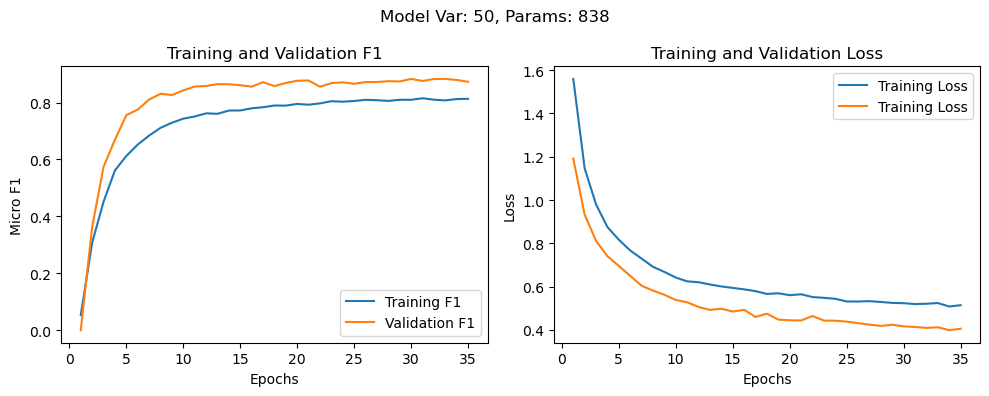

Micro F1 score on the training set: 0.87
Micro F1 score on the validation set: 0.87


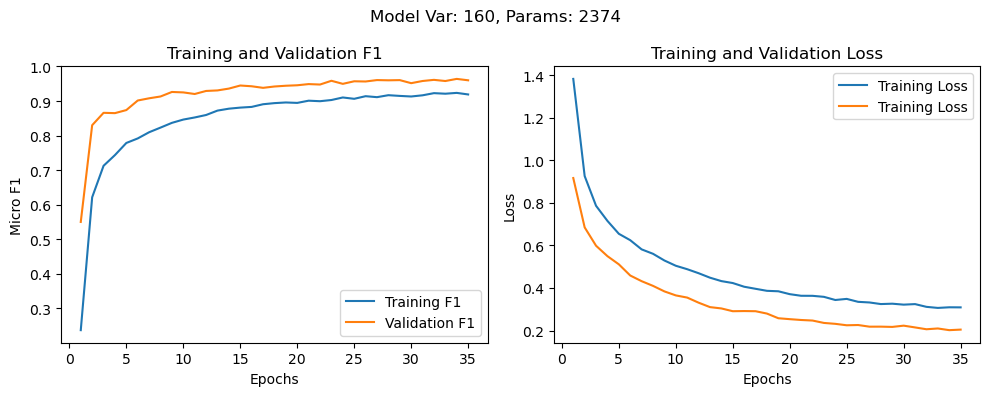

Micro F1 score on the training set: 0.96
Micro F1 score on the validation set: 0.96


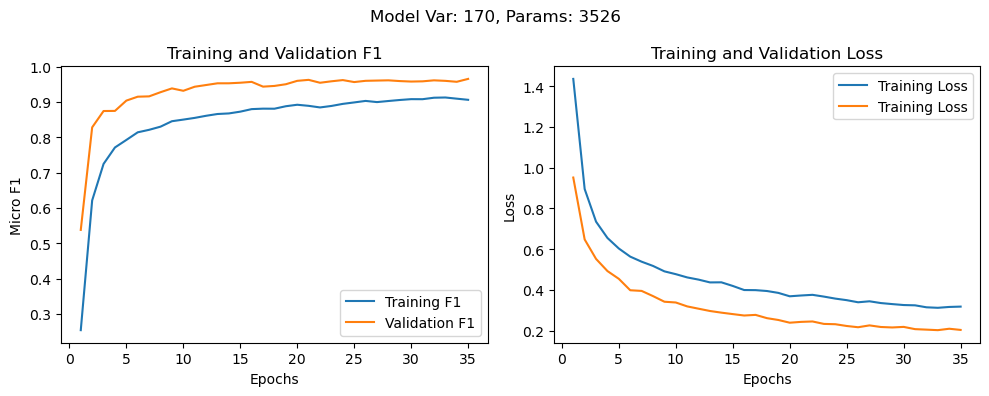

Micro F1 score on the training set: 0.97
Micro F1 score on the validation set: 0.97


In [ ]:
for var in [50, 160, 170]:

    selected_features = variances.nlargest(var).index
    df_selected = df[selected_features]
    ind_features = sorted(df_selected.columns.values.tolist())
    X_train_var = X_train.loc[:,ind_features]
    X_val_var = X_val.loc[:,ind_features]
    X_test_var = X_test.loc[:,ind_features]

    power, pad = detect_power(var)
    train_images = np.pad(X_train_var, ((0, 0), (0, pad)), mode='constant')
    train_images = train_images.reshape((-1, power, power))
    train_images = np.expand_dims(train_images, axis=-1)

    val_images = np.pad(X_val_var, ((0, 0), (0, pad)), mode='constant')
    val_images = val_images.reshape((-1, power, power))
    val_images = np.expand_dims(val_images, axis=-1)

    test_images = np.pad(X_test_var, ((0, 0), (0, pad)), mode='constant')
    test_images = test_images.reshape((-1, power, power))
    test_images = np.expand_dims(test_images, axis=-1)
    
    # Define the architecture
    inputs = Input(shape=(power, power,1))
    conv1 = Conv2D(8, (5, 5), activation='relu', kernel_regularizer=regularizers.l1(0.01))(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    flatten = Flatten()(pool1)
    dense1 = Dense(16, activation='relu')(flatten)
    dropout = Dropout(0.3)(dense1)
    output = Dense(6, activation='softmax')(dropout)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=micro_f1)
    history_sel = model.fit(train_images, y_train_1, batch_size=32, epochs=35, 
                            validation_data=(val_images, y_val_1), verbose=0)
    keras.models.save_model(model, 
                            'models_weights/' + 'Conv' + str(var) + ".h5")

    # Create the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    plt.suptitle("Model Var: " + str(var) + ", Params: " + str(model.count_params()))

    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Micro F1')
    axs[0].set_title('Training and Validation F1')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')


    # Get the training and validation loss from the history
    training_f1 = history_sel.history['micro_f1']
    validation_f1 = history_sel.history['val_micro_f1']
    training_loss = history_sel.history['loss']
    validation_loss = history_sel.history['val_loss']

    # Plot the Training and Validation F1 subplot
    axs[0].plot(range(1, len(training_f1) + 1), training_f1, label = "Training F1")
    axs[0].plot(range(1, len(validation_f1) + 1), validation_f1, label = "Validation F1")

    # Plot the Training and Validation Loss subplot
    axs[1].plot(range(1, len(training_loss) + 1), training_loss, label = "Training Loss")
    axs[1].plot(range(1, len(validation_loss) + 1), validation_loss, label = "Training Loss")

    axs[0].legend()
    axs[1].legend()

    plt.tight_layout()

    # Show the plot
    plt.show()

    a = micro_f1(y_train_1, model.predict(train_images, verbose=0)).numpy()
    print("Micro F1 score on the training set: {:.2f}".format(a))
    b = micro_f1(y_val_1, model.predict(val_images, verbose=0)).numpy()
    print("Micro F1 score on the validation set: {:.2f}".format(b))

As we can see, the models are stable and there are no signs of overfitting. Let's now see the performance on the test set.

In [ ]:
for var in [50, 160, 170]:

    selected_features = variances.nlargest(var).index
    df_selected = df[selected_features]
    ind_features = sorted(df_selected.columns.values.tolist())
    X_train_var = X_train.loc[:,ind_features]
    X_val_var = X_val.loc[:,ind_features]
    X_test_var = X_test.loc[:,ind_features]

    power, pad = detect_power(var)
    test_images = np.pad(X_test_var, ((0, 0), (0, pad)), mode='constant')
    test_images = test_images.reshape((-1, power, power))
    test_images = np.expand_dims(test_images, axis=-1)
    
    model = load_model('models_weights\Conv' + str(var) + '.h5')
    f1 = micro_f1(y_test_1, model.predict(test_images, verbose=0)).numpy()
    print("Micro F1 on test set: {:.2f}, Input size: {}".format(round(f1, 2), var))

Micro F1 on test set: 0.82, Input size: 50
Micro F1 on test set: 0.92, Input size: 160
Micro F1 on test set: 0.92, Input size: 170


# 5. TFLITE

Let's now save our model with Tensorflow Lite, which allows us to operate a post-training quantization. Let's start with the Dynamic range quantization, which statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision. First we save the model and print the number of bytes of each one:

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('ERROR')
import tensorflow.keras.utils as keras_utils

keras_utils.get_custom_objects()['micro_f1'] = micro_f1

In [ ]:
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.models import load_model

folder_path = "models_weights"  # Replace with the actual folder path

print("{:<12s} {:<12s} {:<8s}".format("Model Type", "Input Size", "Bytes"))
print("-" * 40)

for var in [50, 160, 170]:

    for title in ['Dense', 'Conv']:
        # load the model
        filename = title + str(var) + '.h5'
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)

        # Create a converter object
        converter = tf.lite.TFLiteConverter.from_keras_model(model)

        # Enable dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # Start conversion
        tflite_model = converter.convert()

        # Save the model
        path = title + 'Dynamic' + str(var) + '.tflite'
        tflite_model_file = pathlib.Path('models_weights/'+path)
        tflite_model_file.write_bytes(tflite_model)

        # Print the number of bytes
        bytes_count = tflite_model_file.write_bytes(tflite_model)
        print("{:<12s} {:<12d} {:<8d}".format(title, var, bytes_count))
        # Print separator line after every two rows
        if (var % 2 == 0) and (title == 'Conv'):
            print('----------------------------------------')

Model Type   Input Size   Bytes   
----------------------------------------
Dense        50           4968    
Conv         50           5704    
----------------------------------------
Dense        160          19552   
Conv         160          5808    
----------------------------------------
Dense        170          21648   
Conv         170          6960    
----------------------------------------


Now, we prepare the datasets that we will use to evaluate the performances of the three models (3 Dense and 3 CNN).

In [ ]:
test_CNN = np.empty((3,), dtype=object) # numpy to store the input of CNNs
test_Dense = np.empty((3,), dtype=object) # numpy to store the input of Desne

i = 0

for var in [50, 160, 170]:

    # Select the top var features with the highest variance
    selected_features = variances.nlargest(var).index

    # Create a new DataFrame with only the selected features
    df_selected = df[selected_features]

    # Sort the values for taking the best values
    ind_features = sorted(df_selected.columns.values.tolist())

    X_test_var = X_test.loc[:, ind_features]

    test_Dense[i] = X_test_var

    power, pad = detect_power(var)
    test_images = np.pad(X_test_var, ((0, 0), (0, pad)), mode='constant')
    test_images = test_images.reshape((-1, power, power))
    X_test_var_CNN = np.expand_dims(test_images, axis=-1)
    
    test_CNN[i] = X_test_var_CNN

    i += 1

Now, let's save the performance on the test set for the Dense Model

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
i = 0
f1_scores_Dense = []
accuracy_Dense = []
recall_Dense = []

for var in [50,160,170]:
    
    path = 'models_weights/Dense' + 'Dynamic' + str(var) + '.tflite'

    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()

    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Get the input tensor index and shape
    input_index = input_details[0]['index']
    input_shape = input_details[0]['shape']
    input_dim = input_shape[1]

    # Get the output tensor index and shape
    output_index = output_details[0]['index']
    output_shape = output_details[0]['shape']
    num_classes = output_shape[1]

    # Create an empty array to store the predictions
    predictions = np.zeros((2947, 6))

    # Iterate over each instance in X_test
    for j, instance in test_Dense[i].iterrows():
        # Convert the instance to a NumPy array and reshape it
        instance_array = np.array(instance, dtype=np.float32)
        instance_array = instance_array.reshape((1, input_dim))

        # Set the input tensor value
        interpreter.set_tensor(input_index, instance_array)
        # Perform the inference
        interpreter.invoke()

        # Get the output tensor value
        output = interpreter.get_tensor(output_index)

        # Store the prediction
        predictions[j] = output
        
        # Convert the predictions to class labels

    predicted_labels = np.argmax(predictions, axis=1)
    predicted_labels = tf.keras.utils.to_categorical(predicted_labels, num_classes=6)

    # Calculate micro F1 score
    micro_f1 = f1_score(y_test_1, predicted_labels, average='micro')
    accuracy = accuracy_score(y_test_1, predicted_labels)
    recall = recall_score(y_test_1, predicted_labels, average='micro')

    f1_scores_Dense.append(round(micro_f1,2))
    accuracy_Dense.append(round(accuracy,2))
    recall_Dense.append(round(recall,2))
     
    i += 1

and for the CNNs:

In [ ]:
i = 0
f1_scores_CNN = []
accuracy_CNN = []
recall_CNN = []

for var in [50,160,170]:
    
  path = 'models_weights/Conv' + 'Dynamic' + str(var) + '.tflite'

  #Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=path)
  interpreter.allocate_tensors()

   # Get input and output tensor details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Get the input tensor index and shape
  input_index = input_details[0]['index']
  input_shape = input_details[0]['shape']
  input_dim = input_shape[1]**2

  # Get the output tensor index and shape
  output_index = output_details[0]['index']
  output_details[0]['shape']
  num_classes = output_shape[1]

  # Create an empty array to store the predictions
  predictions = np.zeros((2947, 6))

  # Iterate over each instance in test_Dense
  for j, instance in enumerate(test_CNN[i]):
      # Convert the instance to a NumPy array and reshape it
       instance_array = np.array(instance, dtype=np.float32)
       instance_array = instance_array.reshape((1, input_shape[1],input_shape[1],1))
       
       # Set the input tensor value
       interpreter.set_tensor(input_index, instance_array)
       # Perform the inference
       interpreter.invoke()

       # Get the output tensor value
       output = interpreter.get_tensor(output_index)

       # Store the prediction
       predictions[j] = output

      # Convert the predictions to class labels

  predicted_labels = np.argmax(predictions, axis=1)
  predicted_labels = tf.keras.utils.to_categorical(predicted_labels, num_classes=6)

  # Calculate micro F1 score
  micro_f1 = f1_score(y_test_1, predicted_labels, average='micro')
  accuracy = accuracy_score(y_test_1, predicted_labels)
  recall = recall_score(y_test_1, predicted_labels, average='micro')

  f1_scores_CNN.append(round(micro_f1,2))
  accuracy_CNN.append(round(accuracy,2))
  recall_CNN.append(round(recall,2))
  i += 1


Let's now print the micro F1 of the quantized models:

In [ ]:
models = ['Dense', 'CNN']
var = [50, 160, 170]
previous_micro_Dense = [0.85, 0.93, 0.93]
previous_micro_CNN = [0.82, 0.92, 0.92]

print("Model\t\tInput Size\tAccuracy\tRecall\t\tMicro F1\tMicro F1 Before Quant.")
print("------------------------------------------------------------------------------------------------------")

for i in range(len(var)):
    for j in range(len(models)):
        if j == 0:
            f1_val = f1_scores_Dense[i]
            acc = accuracy_Dense[i]
            rec = recall_Dense[i]
            f1_prev = previous_micro_Dense[i]
        else:
            f1_val = f1_scores_CNN[i]
            acc = accuracy_CNN[i]
            rec = recall_CNN[i]
            f1_prev = previous_micro_CNN[i]

        print(f"{models[j]}\t\t{var[i]}\t\t{acc}\t\t{rec}\t\t{f1_val}\t\t{f1_prev}")

    if i < len(var) - 1:
        print("------------------------------------------------------------------------------------------------------")


Model		Input Size	Accuracy	Recall		Micro F1	Micro F1 Before Quant.
------------------------------------------------------------------------------------------------------
Dense		50		0.86		0.86		0.86		0.85
CNN		50		0.82		0.82		0.82		0.82
------------------------------------------------------------------------------------------------------
Dense		160		0.93		0.93		0.93		0.93
CNN		160		0.92		0.92		0.92		0.92
------------------------------------------------------------------------------------------------------
Dense		170		0.93		0.93		0.93		0.93
CNN		170		0.91		0.91		0.91		0.92


As we can see, the micro F1 score on the test set is the same between quantize/not-quantized models.